In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [2]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

In [4]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

In [5]:
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [6]:
enc_1 = Dense(333, activation='sigmoid') 
enc_2 = Dense(444, activation='relu') 
enc_3 = Dense(345, activation='sigmoid') 
enc_mean = Dense(2)
enc_log_var = Dense(2)
dec_3 = Dense(222, activation='sigmoid') 
dec_2 = Dense(617, activation='sigmoid') 
dec_1 = Dense(784, activation='sigmoid') 

In [7]:
a = Input(shape=(784,))
enc_x = enc_2(enc_1(a))
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
def 抽樣(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
z = Lambda(抽樣, output_shape=(2,))([z_mean, z_log_var])
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [10]:
x_hat = dec_1(dec_2(z))
VAE = Model(a, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 333)          261405      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 444)          148296      dense[0][0]                      
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            890         dense_1[0][0]                    
______________________________________________________________________________________________

In [11]:
reconstruction_loss = 784 * losses.mean_squared_error(a, x_hat)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
VAE.add_loss(vae_loss)

In [12]:
VAE.compile(optimizer=Adam())

In [14]:
VAE.fit(X_train, batch_size=617, epochs=9)

Train on 60000 samples
Epoch 1/9
60000/60000 [==============================] - 8s 136us/sample - loss: 58.1252
Epoch 2/9
60000/60000 [==============================] - 6s 107us/sample - loss: 52.7560
Epoch 3/9
60000/60000 [==============================] - 6s 104us/sample - loss: 50.4957
Epoch 4/9
60000/60000 [==============================] - 6s 103us/sample - loss: 49.1394
Epoch 5/9
60000/60000 [==============================] - 6s 102us/sample - loss: 47.1946
Epoch 6/9
60000/60000 [==============================] - 6s 102us/sample - loss: 46.8079
Epoch 7/9
60000/60000 [==============================] - 6s 101us/sample - loss: 46.7157
Epoch 8/9
60000/60000 [==============================] - 6s 107us/sample - loss: 46.6654
Epoch 9/9
60000/60000 [==============================] - 6s 108us/sample - loss: 46.6055


In [17]:
VAE_Encoder = Model(a, z_mean)

In [18]:
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 333)               261405    
_________________________________________________________________
dense_1 (Dense)              (None, 444)               148296    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 890       
Total params: 410,591
Trainable params: 410,591
Non-trainable params: 0
_________________________________________________________________


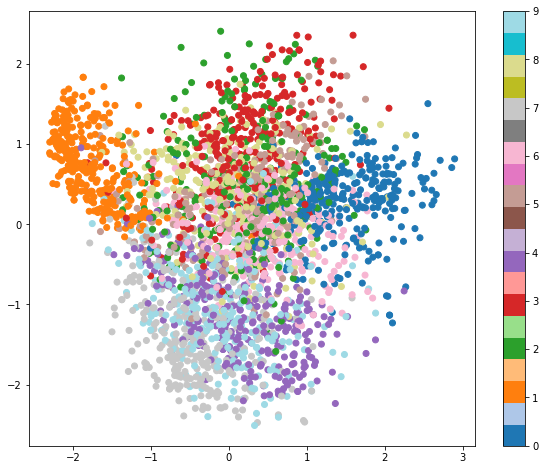

In [19]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [20]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 617)               1851      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               484512    
Total params: 486,363
Trainable params: 486,363
Non-trainable params: 0
_________________________________________________________________


In [21]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [23]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

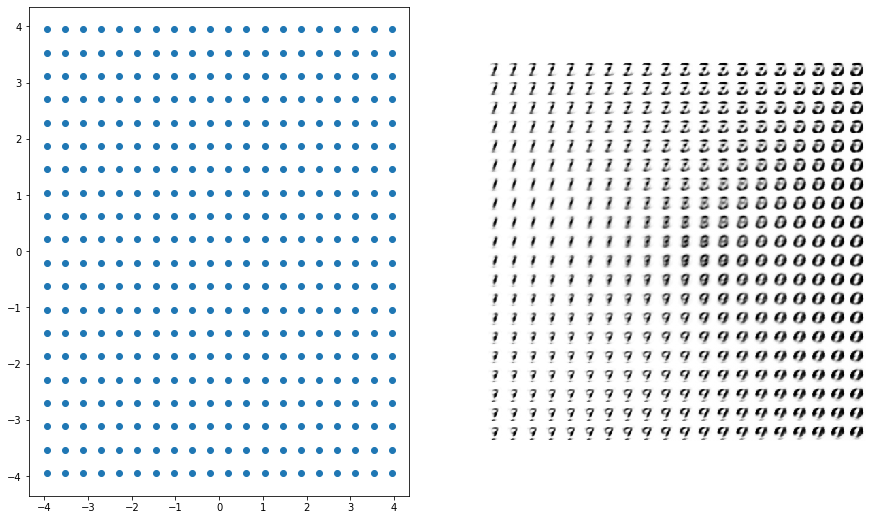

In [24]:
plt.figure(figsize=(15, 9))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [25]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [26]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [27]:
from ipywidgets import interact, IntSlider, FloatSlider
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>